In [71]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
plt.rc("font", family="Malgun Gothic") # wind 기본 한글폰트

# 전처리

## 주유소 가격

In [2]:
# 다운로드한 파일 불러오기
station = pd.read_csv('data/주유소_평균판매가격_제품별.csv', encoding='cp949')

# row데이터 : 2010년 1월 2일 ~ 2021년 9월 1일 (날짜 조정) // 주유소 금액은 하루전 가격으로 발표 
station['날짜']=pd.to_datetime(station['구분'].str.replace('년','-').str.replace('월','-').str.replace('일',''))
station['날짜'] = station['날짜'] - datetime.timedelta(days=1)
station.drop(['구분'], axis=1, inplace=True)

# 보통휘발유의 30일 이전대비 증감비율 계산 // 30일 이전 데이터 없는 경우 NaN 처리
for idx in range(len(station)) :
    try :
        temp = ((station.loc[idx, '보통휘발유'] - station.loc[idx-30, '보통휘발유']) / station.loc[idx-30, '보통휘발유']).round(6)
        station.loc[idx, '보휘-30'] = temp
    except KeyError as e :
        station.loc[idx, '보휘-30'] = np.nan
        
station = station[['날짜', '고급휘발유', '보통휘발유', '자동차용경유', '실내등유', '보휘-30']]
station_df = station.copy()    # 새로운 DF에 복사

# 파일 저장
station_df.to_csv('data/station_df.csv', index=None)

## 국제 원유 가격

In [10]:
# 다운로드한 파일 불러오기
crude = pd.read_csv('data/국제_원유가격20100102_20210901.csv', encoding='cp949')

# row데이터 : 2010년 1월 2일 ~ 2021년 9월 1일 (날짜 조정) // 원유 금액은 시차로 인하여 전날 요금을 조사
crude['기간'] = '20'+crude['기간']
crude['날짜']=pd.to_datetime(crude['기간'].str.replace('년','-').str.replace('월','-').str.replace('일',''))
crude['날짜'] = crude['날짜'] - datetime.timedelta(days=1)
crude.drop(['기간'], axis=1, inplace=True)

# '-'로 되어있는 결측치 NaN으로 변경 + 숫자로 타입변환
crude.replace('-', np.nan, inplace=True)
crude['Dubai'] = pd.to_numeric(crude['Dubai'])
crude['Brent'] = pd.to_numeric(crude['Brent'])
crude['WTI'] = pd.to_numeric(crude['WTI'])

# 세종류 원유의 평균값 추출
crude['평균'] = crude[['Dubai', 'Brent', 'WTI']].mean(axis=1).round(2)

# 평균의 30일 이전대비 증감비율 계산 : 30일 이전 데이터 없는 경우 NaN 처리
for idx in range(len(crude)) :
    try :
        temp = ((crude.loc[idx, '평균'] - crude.loc[idx-30, '평균']) / crude.loc[idx-30, '평균']).round(6)
        crude.loc[idx, '평균-30'] = temp
    except KeyError as e :
        crude.loc[idx, '평균-30'] = np.nan

crude = crude[['날짜', 'Dubai', 'Brent', 'WTI', '평균', '평균-30']]
crude_df = crude.copy()    # 새로운 DF에 복사

# 파일 저장
crude_df.to_csv('data/crude_df.csv', index=None)

## 정유사 공급가격

In [9]:
# 다운로드한 파일 불러오기
refinery = pd.read_csv('data/정유사_주간공급가격_제품별.csv', encoding='cp949')

# 정유사 금액은 전주의 일요일(-10)~토요일(-4) 기준 -> 전주 수요일 기준으로 임의날짜 조정
refinery['날짜'] = '2009-12-30'
refinery['날짜'] = pd.to_datetime(refinery['날짜'])
for idx in range(1, len(refinery)) :
    refinery['날짜'][idx] = refinery['날짜'][0] + datetime.timedelta(days=(7 * idx))
refinery.drop(0, inplace=True)
refinery.index = range(refinery.shape[0])

# 보통휘발유의 4주전 대비 증감비율 계산 : 30일 이전 데이터 없는 경우 NaN 처리
for idx in range(len(refinery)) :
    try :
        temp = ((refinery.loc[idx, '보통휘발유'] - refinery.loc[idx-4, '보통휘발유']) / refinery.loc[idx-4, '보통휘발유']).round(6)
        refinery.loc[idx, '보휘-4w'] = temp
    except KeyError as e :
        refinery.loc[idx, '보휘-4w'] = np.nan

refinery = refinery[['날짜', '고급휘발유', '보통휘발유', '자동차용경유', '실내등유', '보휘-4w']]
refinery_df = refinery.copy()    # 새로운 DF에 복사

# 파일 저장
refinery_df.to_csv('data/refinery_df.csv', index=None)

## 주유소별 역대 가격

### 반복 다운로드를 위한 웹크롤링

In [ ]:
# 사이트의 설정상 월단위 다운로드 가능

import pyautogui
import time

pyautogui.click(x=650, y=809, clicks=2)
date_list = pd.read_csv('data/date.csv')
date_list = np.array(date_list[3:140])

for date in date_list:
    # 시작날짜 입력창 더블클릭
    start = str(date[0])
    end = str(date[1])
    pyautogui.click(x=1045, y=547, clicks=1)
    pyautogui.click(x=655, y=809, clicks=2)
    pyautogui.typewrite('')
    pyautogui.typewrite(start)
    time.sleep(1)
    # 종료날짜 입력창 더블클릭
    pyautogui.click(x=775, y=807, clicks=2)
    time.sleep(1)
    pyautogui.typewrite('')
    pyautogui.typewrite(end)
    # CSV저장 버튼 클릭
    pyautogui.click(x=1477, y=859, clicks=1)
    time.sleep(3)
     # 계속진행하시겠습니까? 확인버튼 클릭
    pyautogui.click(x=1063, y=208, clicks=1)
    time.sleep(80)

### 다운로드된 140개 csv 파일 합치기

In [ ]:
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-001\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
cnt =0 
Data_soil =pd.DataFrame()
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-001\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)
    
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-002\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-002\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)

In [ ]:
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-003\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-003\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)
    
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-004\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-004\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)

In [ ]:
# 파일 저장
Data_soil.to_csv('Data_oilstation.csv', index=False, encoding='cp949')

### 휘발유 누적평균가격 구하기

In [12]:
# 휘발유 평균값에 대한 편차를 구하기 위한 함수 정의
def gap(a,b):
    if a==0:
        return np.nan
    else:
        return a-b

In [13]:
price = pd.read_csv('data/Data_oilstation.csv', encoding='CP949')
price = price.dropna()
pivot = price.pivot_table(index='기간', values='휘발유', aggfunc='mean').reset_index()
pivot.columns = ('기간','휘발유_평균')
merged = pd.merge(price, pivot, on='기간')
merged['휘발유_편차'] = list(map(gap, merged['휘발유'], merged['휘발유_평균']))

# high_price_rank = 높은가격순  // low_price_rank = 낮은가격순
high_price_rank = merged.pivot_table(index=['상호','주소'], values='휘발유_편차', aggfunc='mean').sort_values(by='휘발유_편차', ascending=False)
low_price_rank = merged.pivot_table(index=['상호','주소'], values='휘발유_편차', aggfunc='mean').sort_values(by='휘발유_편차')
high_price_rank = high_price_rank.reset_index()
low_price_rank = low_price_rank.reset_index()

# 파일 저장
high_price_rank.to_csv('data/high_price_rank.csv', encoding='CP949', index=None)
low_price_rank.to_csv('data/조별 과제/low_price_rank.csv', encoding='CP949', index=None)

UnicodeDecodeError: 'cp949' codec can't decode byte 0x80 in position 10: illegal multibyte sequence

## 원유평균 + 정유사 보통휘발유 + 주유소 보통휘발유

In [14]:
station_df = pd.read_csv('data/station_df.csv')
crude_df = pd.read_csv('data/crude_df.csv')
refinery_df = pd.read_csv('data/refinery_df.csv')

In [15]:
temp1 = station_df[['날짜', '보통휘발유']]
temp1.columns = ['날짜', '주유소 보통휘발유']
temp2 = refinery_df[['날짜', '보통휘발유']]
temp2.columns = ['날짜', '정유사 보통휘발유']
temp3 = crude_df[['날짜', '평균']]
temp3.columns = ['날짜', '원유 평균']
temp4 = pd.merge(temp1, temp2)
temp5 = pd.merge(temp4, temp3)
temp5.index = range(temp5.shape[0])

# 파일 저장
temp5.to_csv('data/gasoline.csv', index=None)

# 저장된 파일 확인

In [3]:
station_df = pd.read_csv('data/station_df.csv')
station_df.head(1)

,날짜,고급휘발유,보통휘발유,자동차용경유,실내등유,보휘-30
0,2010-01-01,1848.43,1641.12,1433.12,1020.11,NaN


In [4]:
crude_df = pd.read_csv('data/crude_df.csv')
crude_df.head(1)

,날짜,Dubai,Brent,WTI,평균,평균-30
0,2010-01-03,78.27,80.12,81.51,79.97,NaN


In [5]:
refinery_df = pd.read_csv('data/refinery_df.csv')
refinery_df.head(1)

,날짜,고급휘발유,보통휘발유,자동차용경유,실내등유,보휘-4w
0,2010-01-06,1712.71,1597.16,1373.69,917.94,NaN


In [6]:
high_price_rank = pd.read_csv('data/high_price_rank.csv', encoding='cp949')
high_price_rank.head(1)

,상호,주소,휘발유_편차
0,뉴서울(강남),서울 강남구 언주로 716,592.571216


In [7]:
low_price_rank = pd.read_csv('data/low_price_rank.csv', encoding='cp949')
low_price_rank.head(1)

,상호,주소,휘발유_편차
0,청전주유소,전남 담양군 담양읍 무정로 76,-161.656127


In [8]:
gasoline = pd.read_csv('data/gasoline.csv') # 주유소, 정유사, 원유 날짜별로 머지한것
gasoline.head(1)

,날짜,주유소 보통휘발유,정유사 보통휘발유,원유 평균
0,2010-01-06,1649.43,1597.16,81.64


# 참고해야하는 부분!!!!!!----------------------------

In [9]:
# 환율 정보 넣어서 국제유가 계산

In [10]:
#판다스 디스플레이 옵션
pd.options.display.max_columns = 29
pd.options.display.max_rows = 10000

#그래프 설정
%matplotlib inline
%config InlineBackend.figure_format='retina'
#한글설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)
#경고 메세지 안보이게 하기
import warnings
warnings.filterwarnings(action='ignore')

In [72]:
#환율, 단위통일, 세금부분 적용
from dateutil.parser import parse

def tax_add(price, date):
    if date < parse('2018/11/6'):
        return price
    elif parse('2018/11/6') <= date < parse('2019/5/7'):
        return price+111.39
    elif parse('2019/5/7') <= date < parse('2019/9/1'):
        return price+52.17
    else:
        return price

# 한국은행 경제통계시스템
Exchange_rate = pd.read_csv('data/달러환율(매매기준).csv', encoding='cp949')
Exchange_rate = Exchange_rate[3:2893]
Exchange_rate.columns = ['날짜', '환율']

Exchange_rate['날짜']=pd.to_datetime(Exchange_rate['날짜'].str.replace('/','-')) #날짜 datetime 형식으로 변환
Exchange_rate

gasoline = pd.read_csv('data/gasoline.csv') # 주유소, 정유사, 원유 날짜별로 머지한것 파일 읽어오기
gasoline['날짜'] = pd.to_datetime(gasoline['날짜']) #날짜 형식 datetime으로 변경

#날짜 맞추는 과정과 결측치 처리
gasoline2 = pd.merge(gasoline, Exchange_rate, how='left') #날짜 맞추기
gasoline2 = gasoline2.fillna(method='ffill') #결측치 처리
gasoline2

#gasoline2의 환율 문자에서 숫자로 형식 변경
gasoline2['환율']=gasoline2['환율'].str.replace(',','')
gasoline2=gasoline2.astype({'환율':'float64'})

#환율 계산과 그리고 베럴을 리터로 변환
gasoline2['환율반영 원유'] = gasoline2['원유 평균'] * gasoline2['환율']
gasoline2['환율반영 원유'] = gasoline2['환율반영 원유']/158.9

#세금반영
gasoline2['주유소 보통휘발유 세금반영']=list(map(tax_add, gasoline2['주유소 보통휘발유'], gasoline2['날짜']))
gasoline2['정유사 보통휘발유 세금반영']=list(map(tax_add, gasoline2['정유사 보통휘발유'], gasoline2['날짜']))

# 파일 저장
gasoline2.to_csv('data/gasoline2.csv', encoding='CP949', index=None)


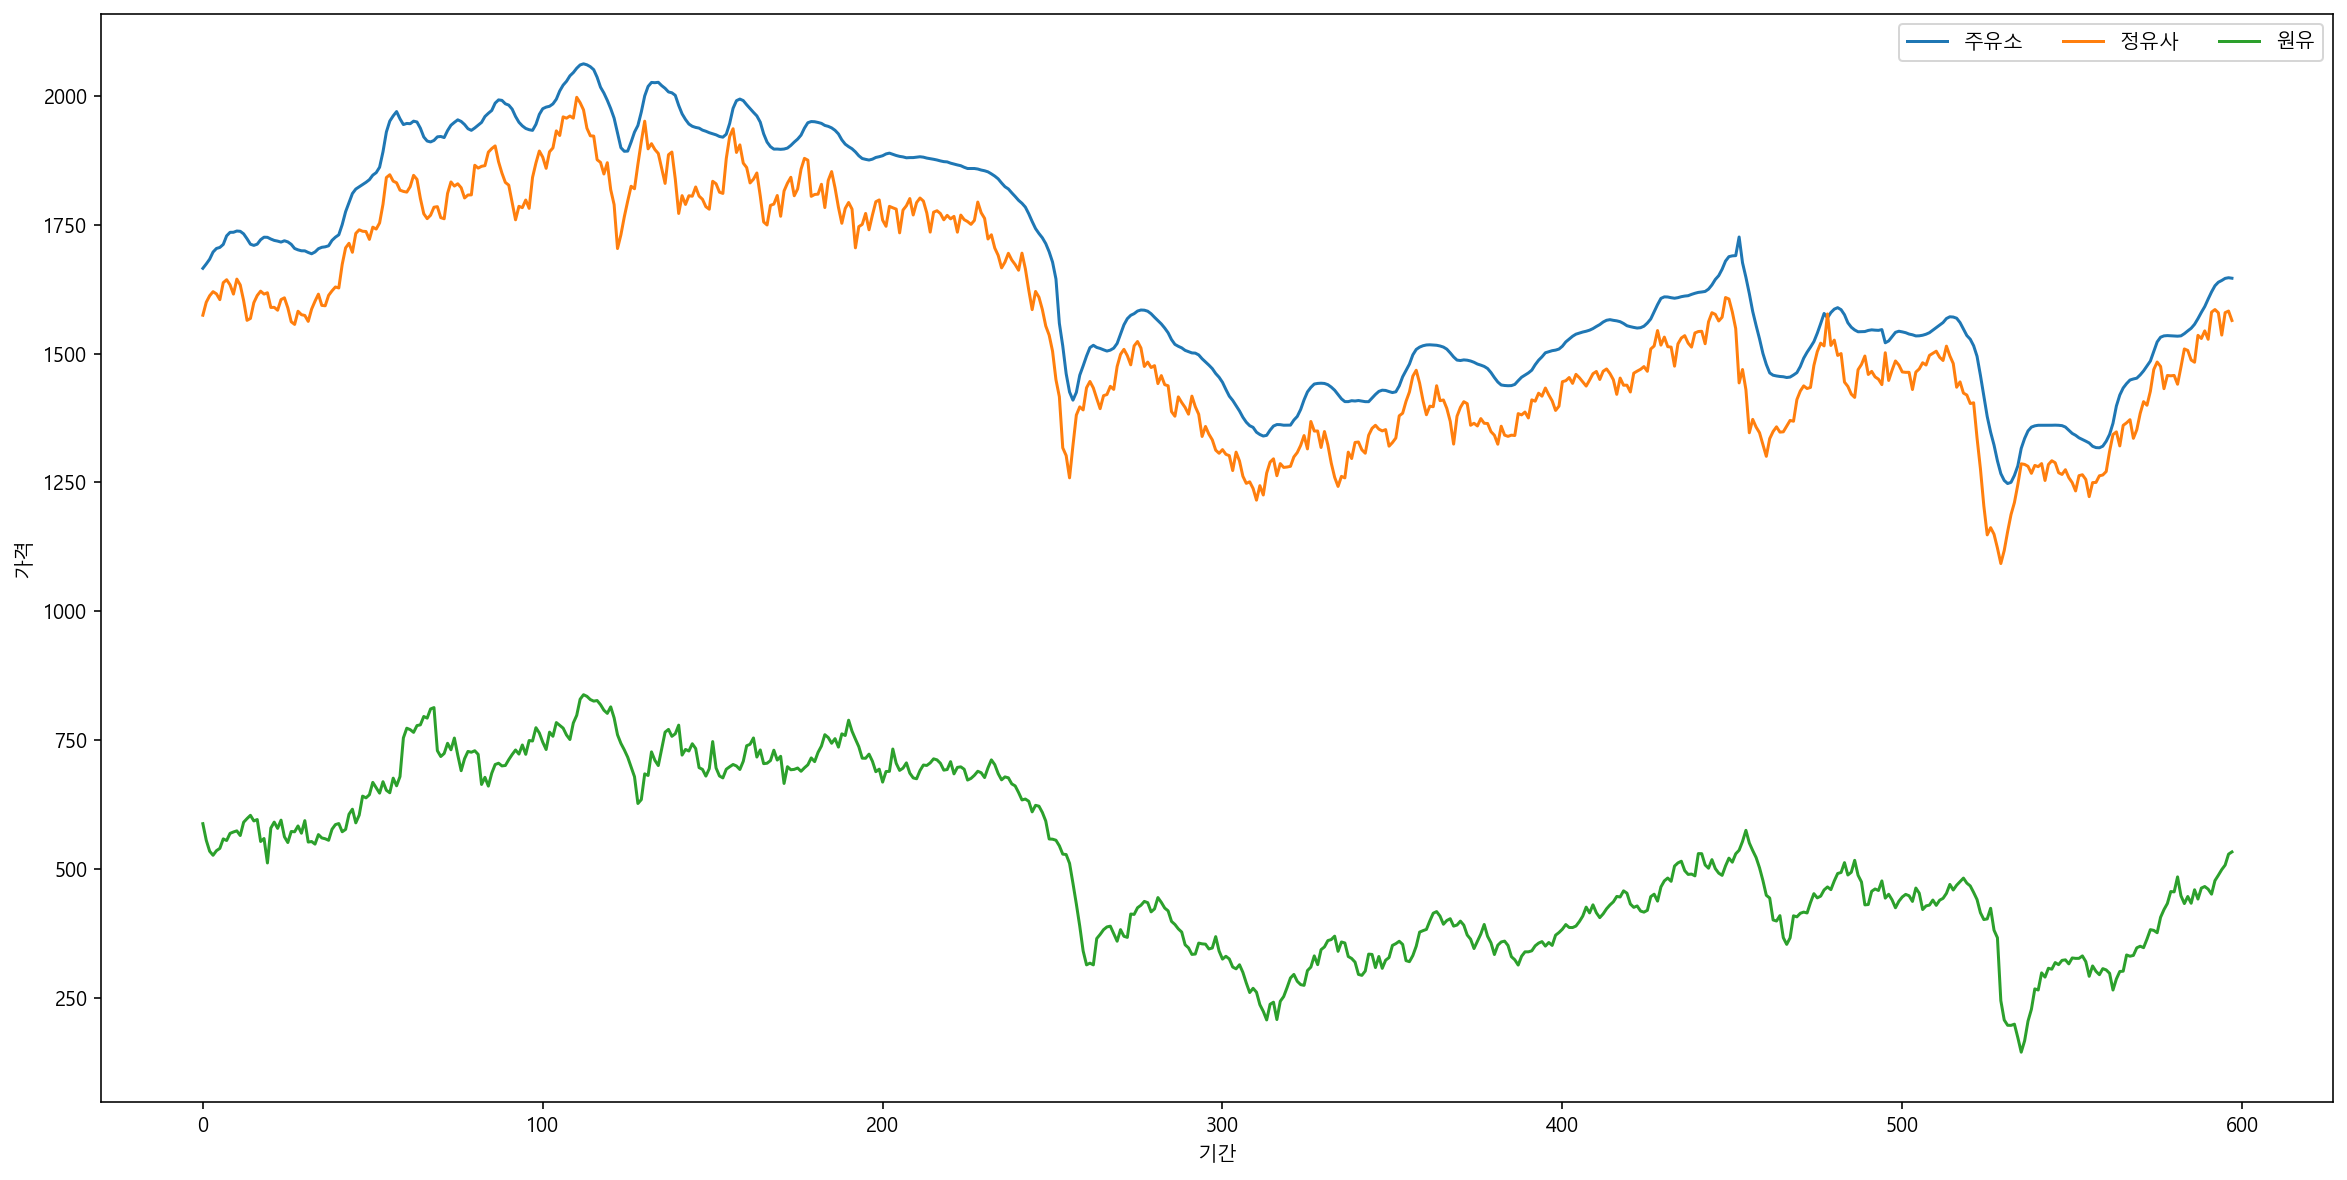

In [73]:
#날짜 통일하여 원유, 정유사, 주유소 그래프 그리기

# 원유가 주유소에 공급되기 까지 과정
# http://www.petroleum.or.kr/ko/sub02/02_8.php 대한석유협회 : 우리나라에서 배가 출발해 다시 돌아와 정유소가는데 약45일 => 42일로 간주
# http://www.petroleum.or.kr/ko/sub02/02_8.php 중앙일보 뉴스 : 정유소에서 정유후 주유소로 가는데 걸리는 시간 7-10 => 7일로 간주

#gasoline2['주유소 보통휘발유'].iloc[7:]  -> 주유소의 처음 7행은 이전 원유이기에 삭제
#gasoline2['정유사 보통휘발유'].iloc[6:-1] -> 정유사의 처음 6행은 이전 원유이여 삭제했고 뒷 일행은 아직 정제중이라 삭제
#gasoline2['환율반영 원유'].iloc[:-7] -> 뒷7행은 배송중인 원유이기에 삭제

#Question ==> 정유사에 주유소 세금을적용

gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

plt.plot(a,label='주유소')
plt.plot(b,label='정유사')
plt.plot(c,label='원유')
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=3)

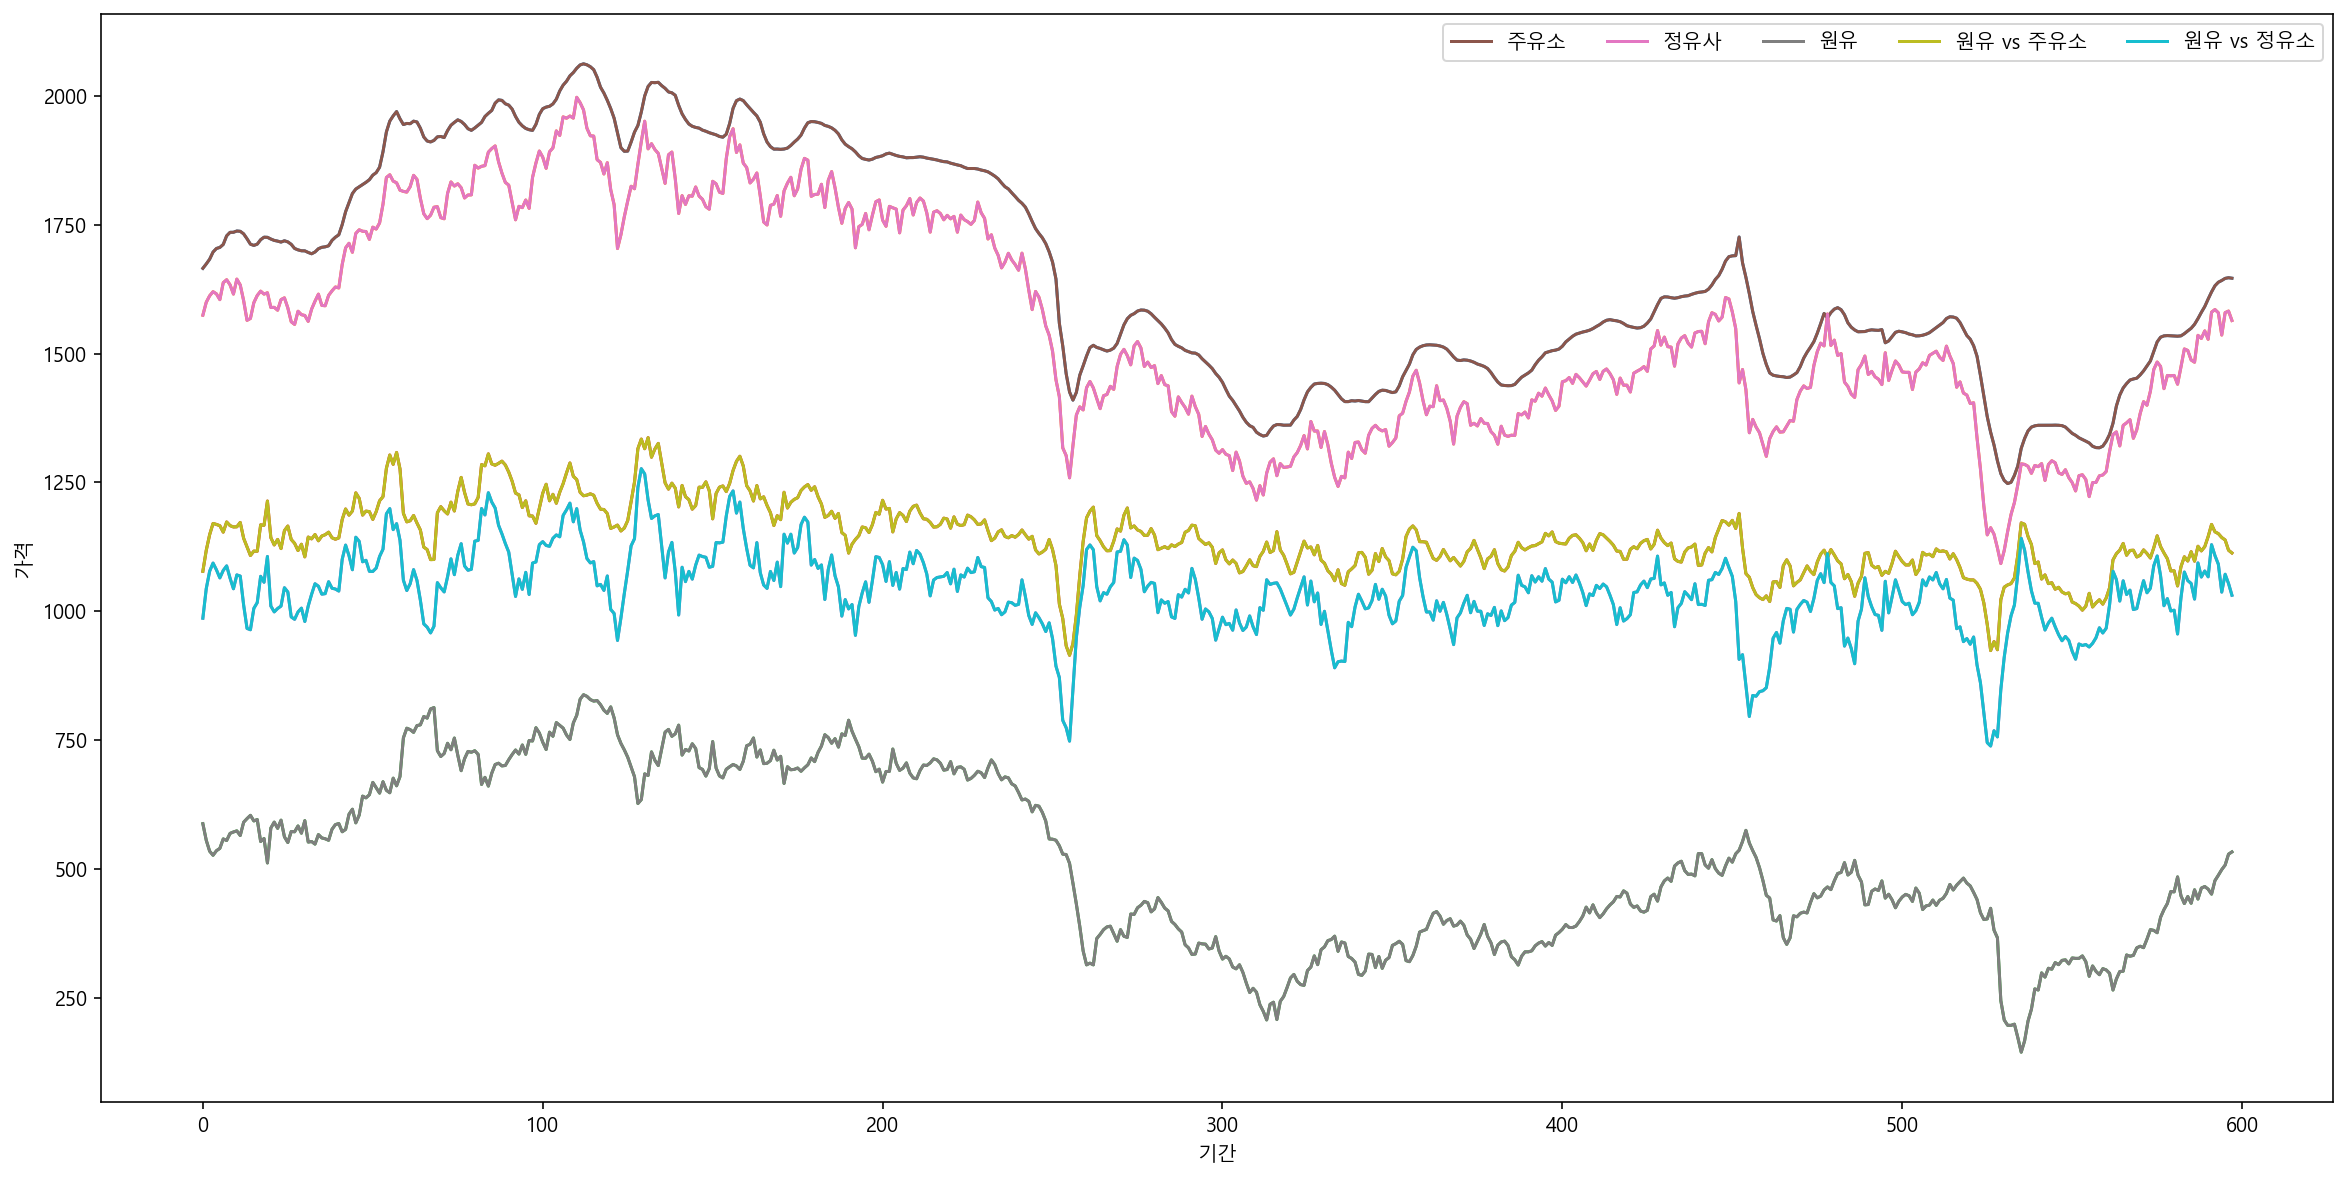

In [74]:
# 기존 그래프에 원유와 주유소차이, 원유와 정유소차이 그래프 추가
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

e = d['원유와 주유소가격 차이'] = d['주유소 보통휘발유 세금반영']-d['환율반영 원유']
f = d['원유와 정유사가격 차이'] = d['정유사 보통휘발유 세금반영']-d['환율반영 원유']

plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(e)
plt.plot(f)

plt.plot(a,label='주유소')
plt.plot(b,label='정유사')
plt.plot(c,label='원유')
plt.plot(e,label='원유 vs 주유소')
plt.plot(f,label='원유 vs 정유소')

plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=5)

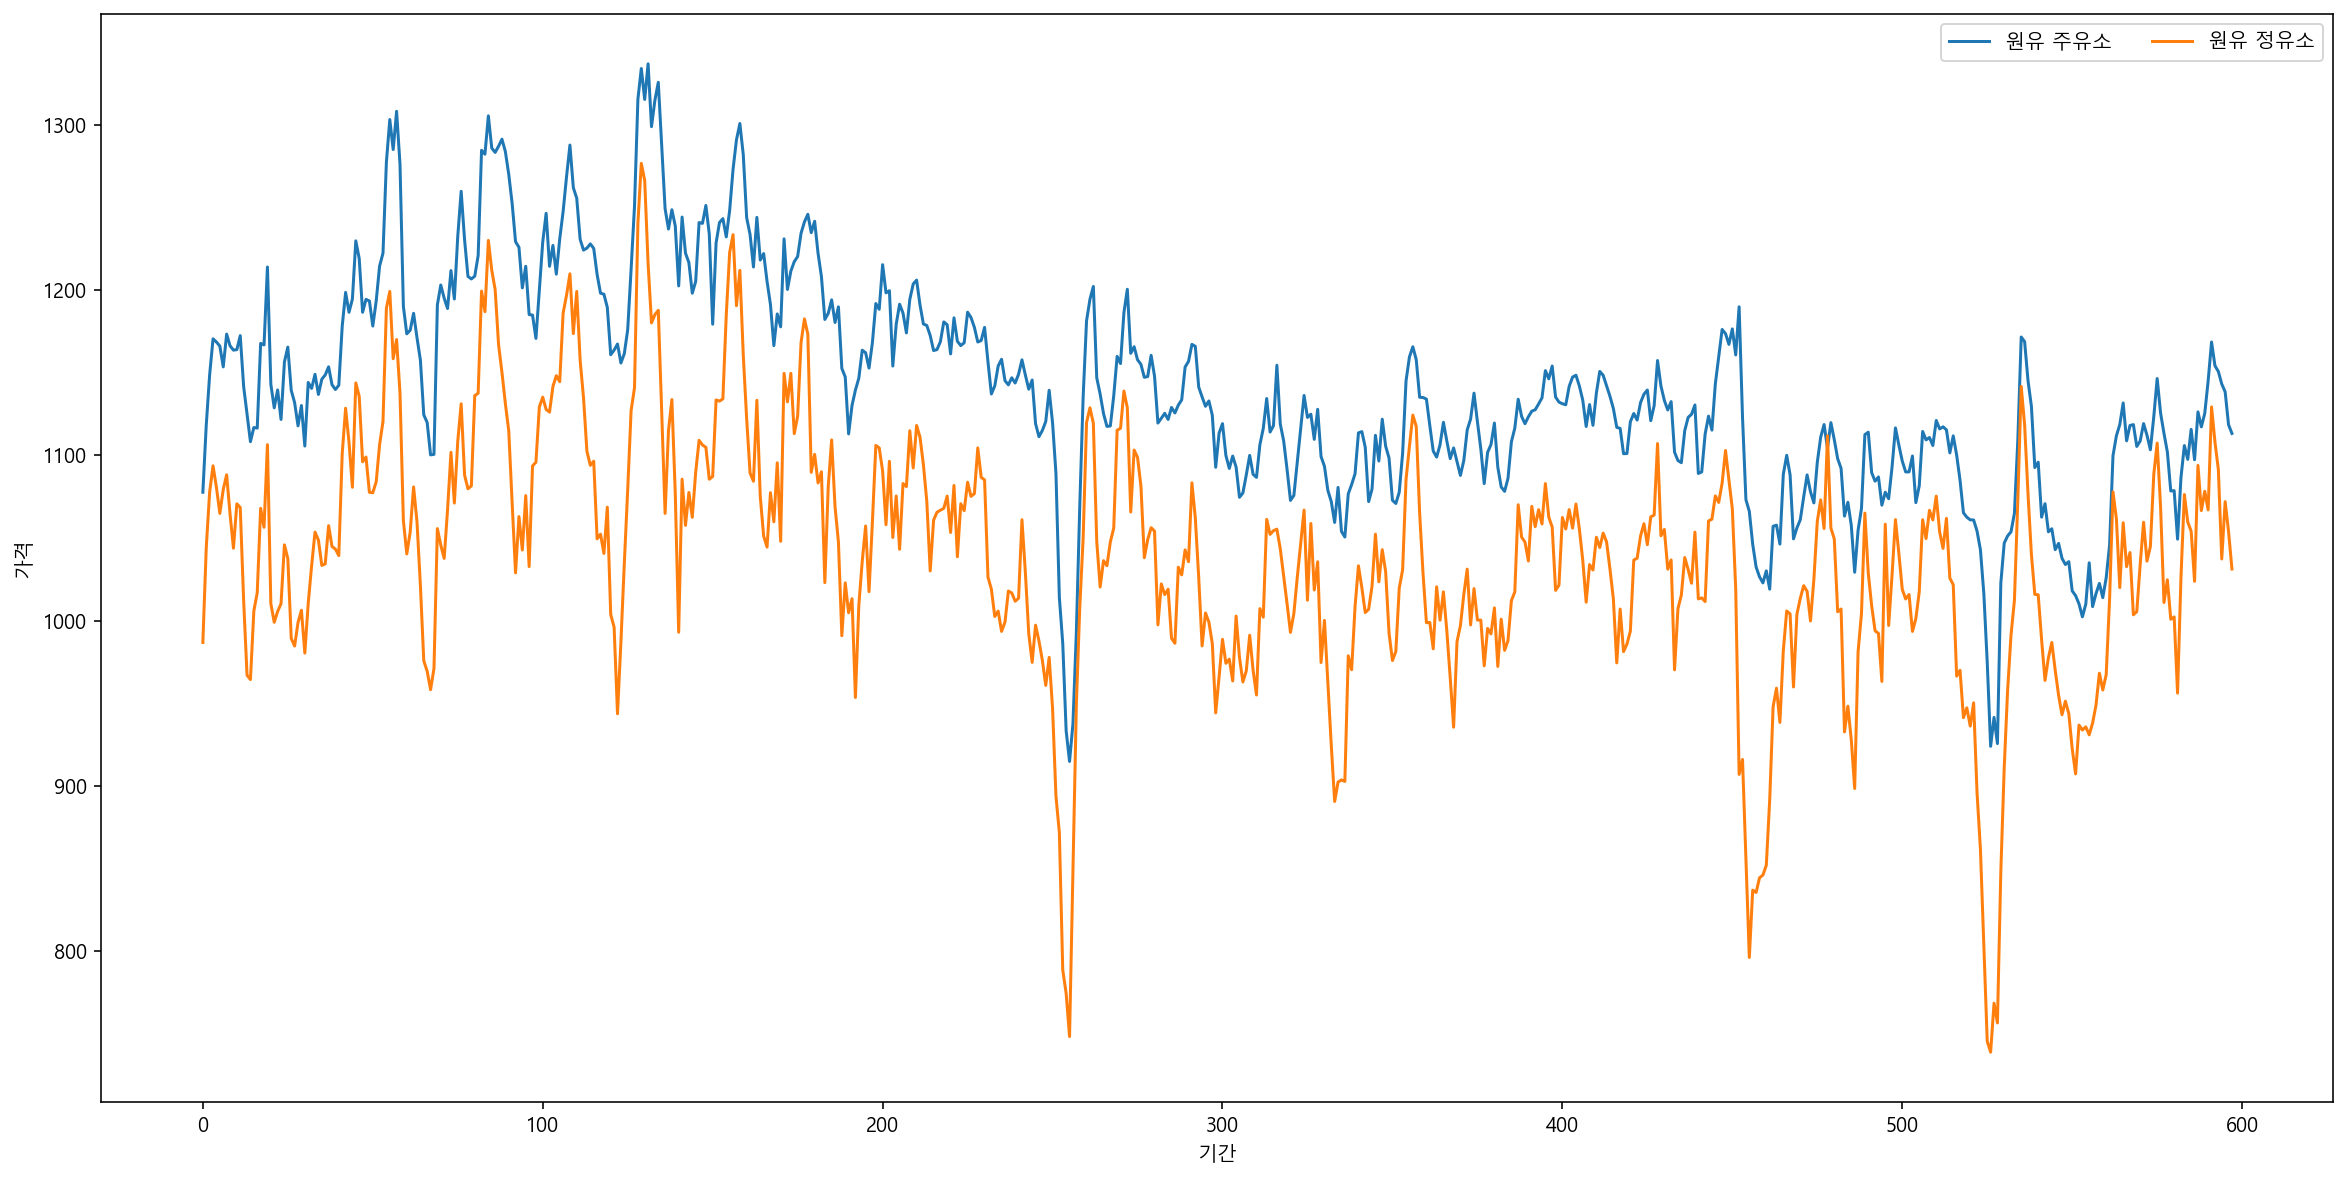

In [75]:
# 원유와 주유소차이, 원유와 정유소차이 그래프 추가
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

e= d['원유와 주유소가격 차이'] = d['주유소 보통휘발유 세금반영']-d['환율반영 원유']
f= d['원유와 정유사가격 차이'] = d['정유사 보통휘발유 세금반영']-d['환율반영 원유']
plt.plot(e,label='원유 주유소')
plt.plot(f,label='원유 정유소')
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=2)

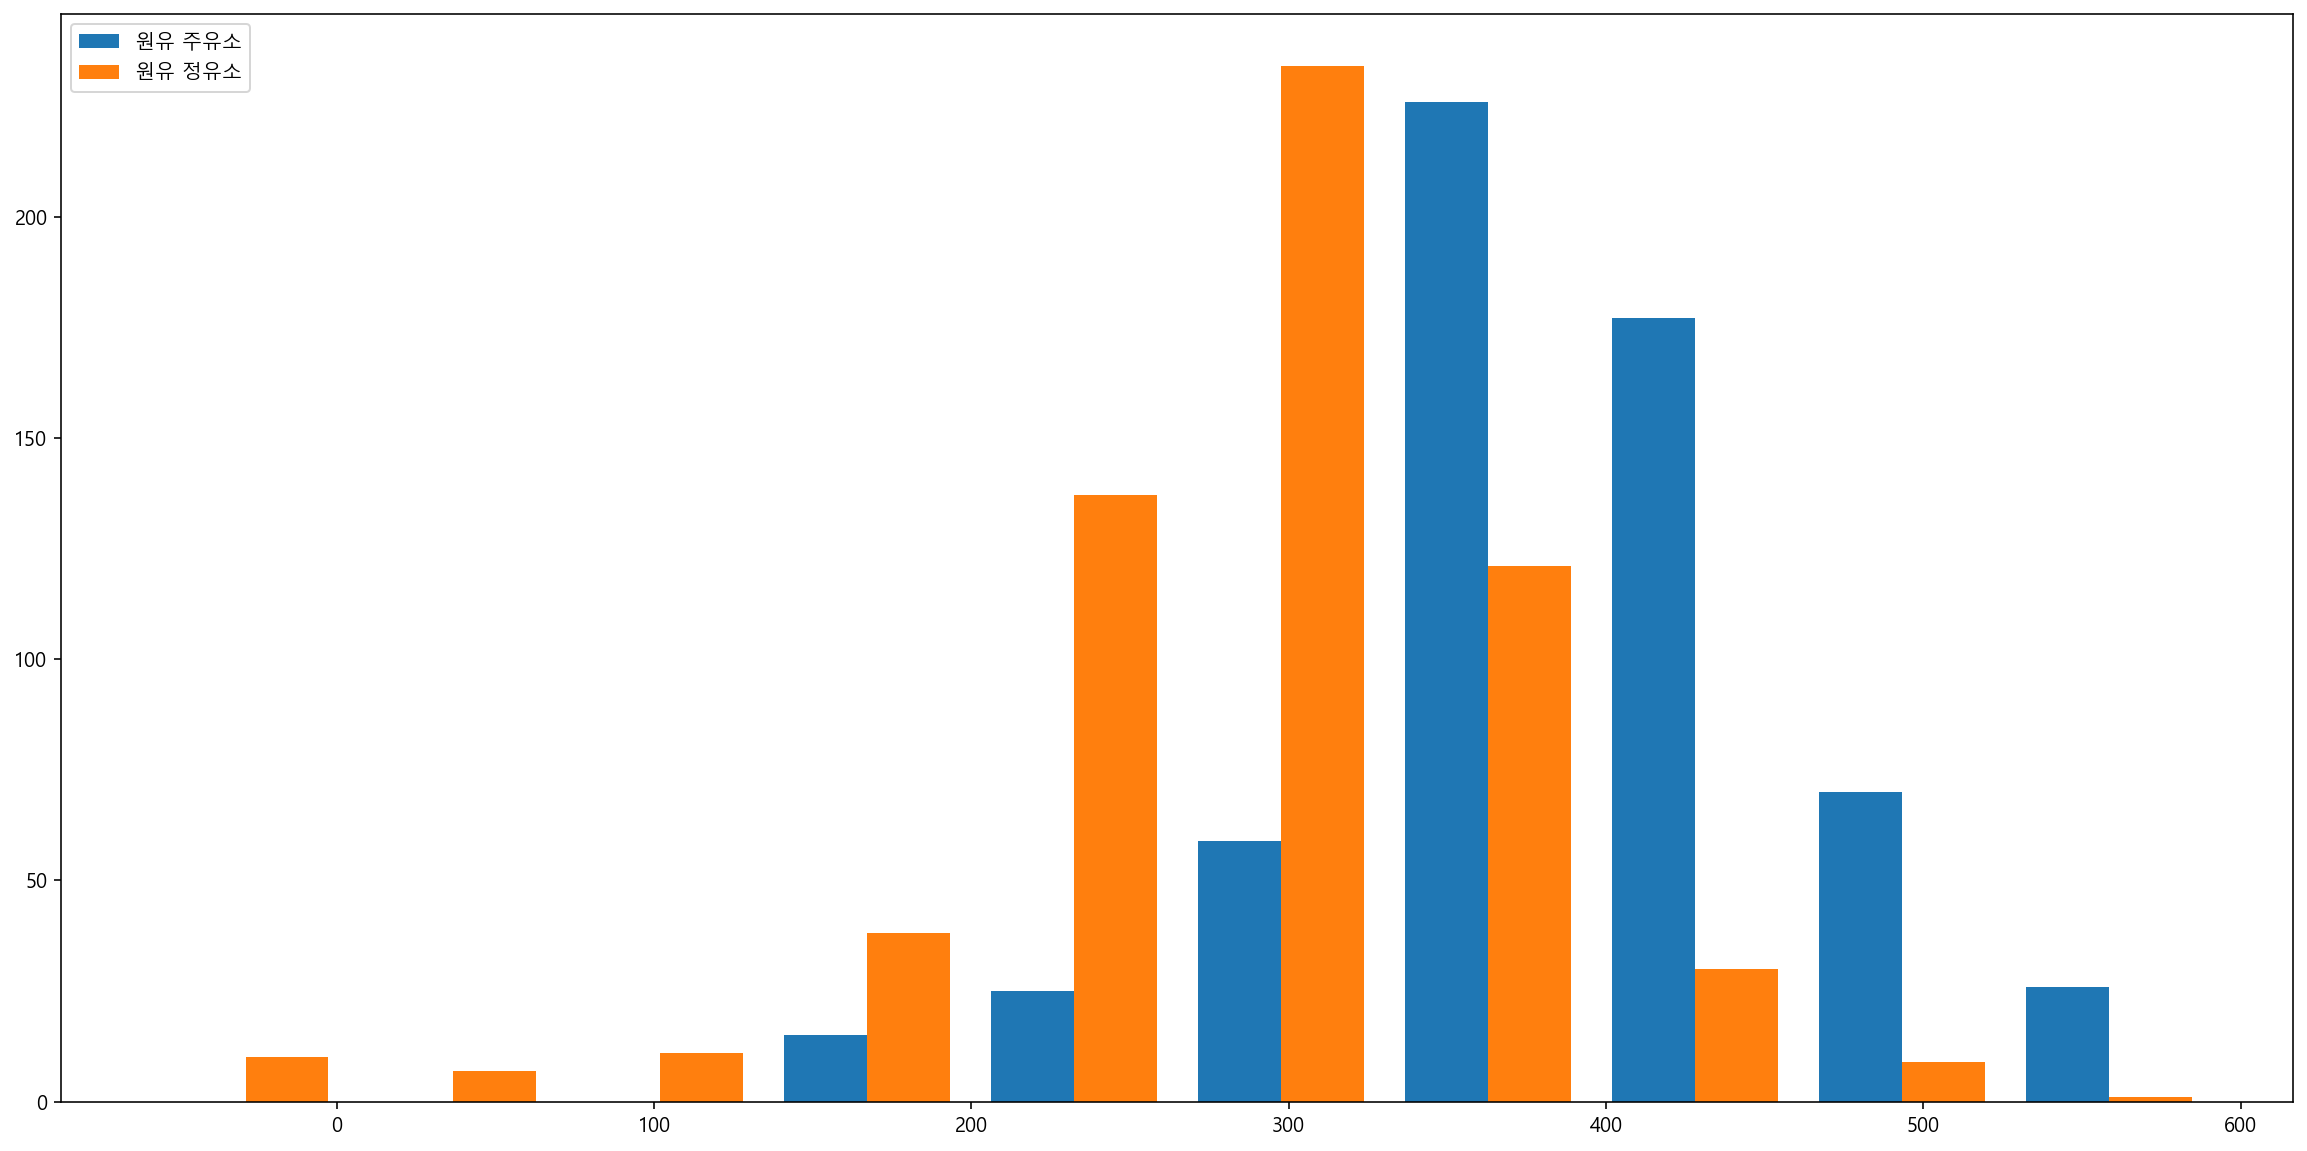

In [22]:
#원유와 주유소 가격차, 원유와 정유소 가격차를 알아보기 위한 희스토그램 
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

e= d['원유와 주유소가격 차이'] = d['주유소 보통휘발유 세금반영']-d['환율반영 원유']
f= d['원유와 정유사가격 차이'] = d['정유사 보통휘발유 세금반영']-d['환율반영 원유']


plt.hist([e,f],label=['원유 주유소','원유 정유소'])
plt.legend(loc='upper left')

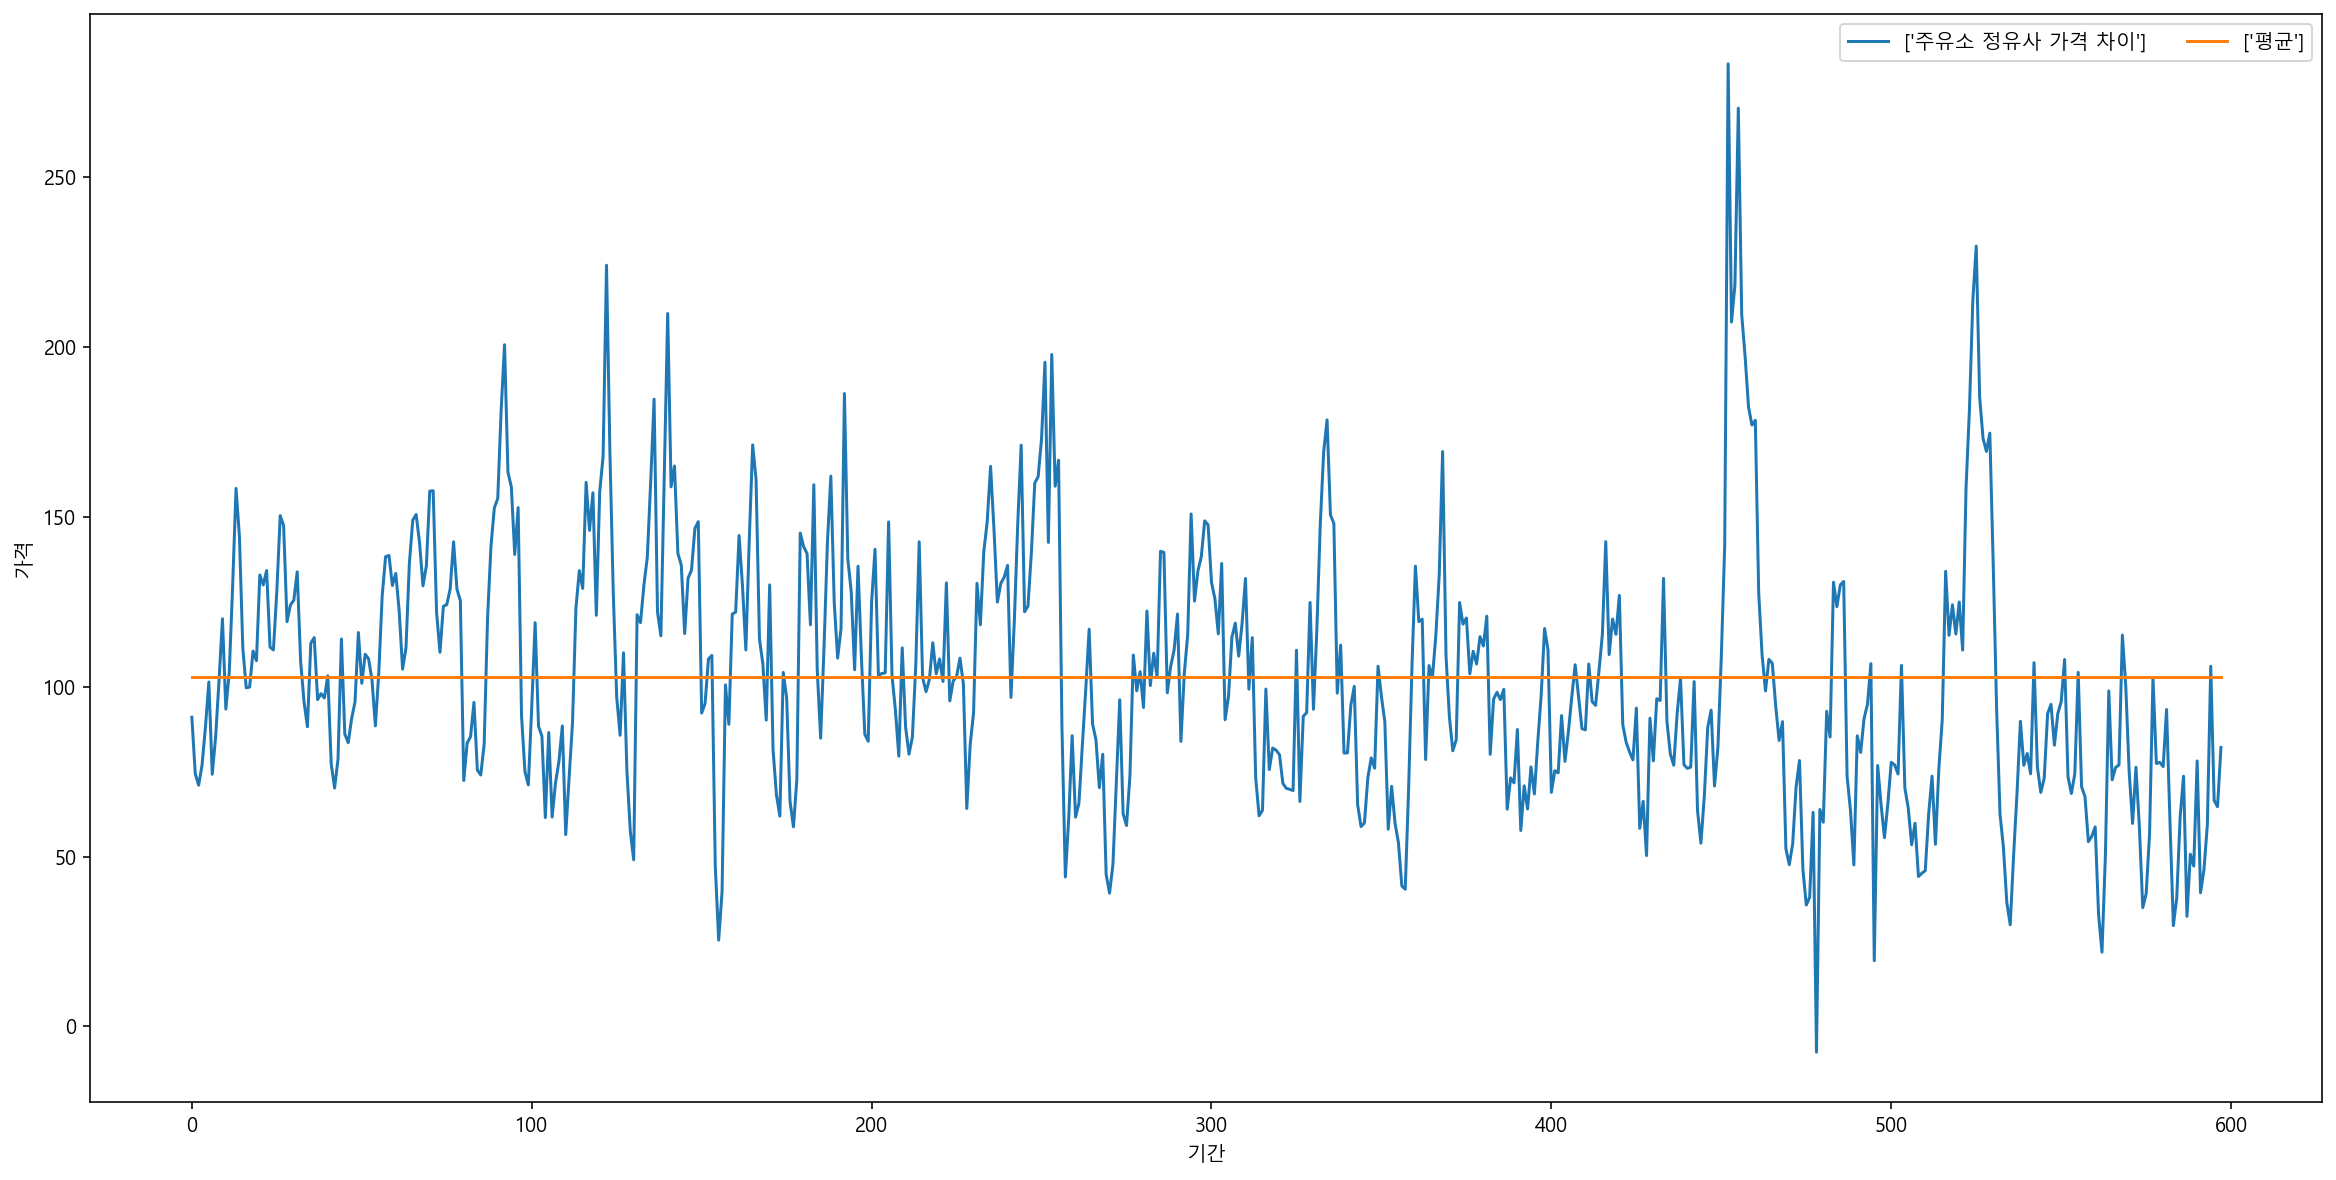

In [131]:
# 주유소 정유소 가격차이와 평균
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']


e = a-b
e = e.to_frame()
e['평균'] = pd.Series()
e['평균'] = e['평균'].apply(lambda x : e.mean())

plt.plot(e[0], label=['주유소 정유사 가격 차이'])
plt.plot(e['평균'], label=['평균'])
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=2)

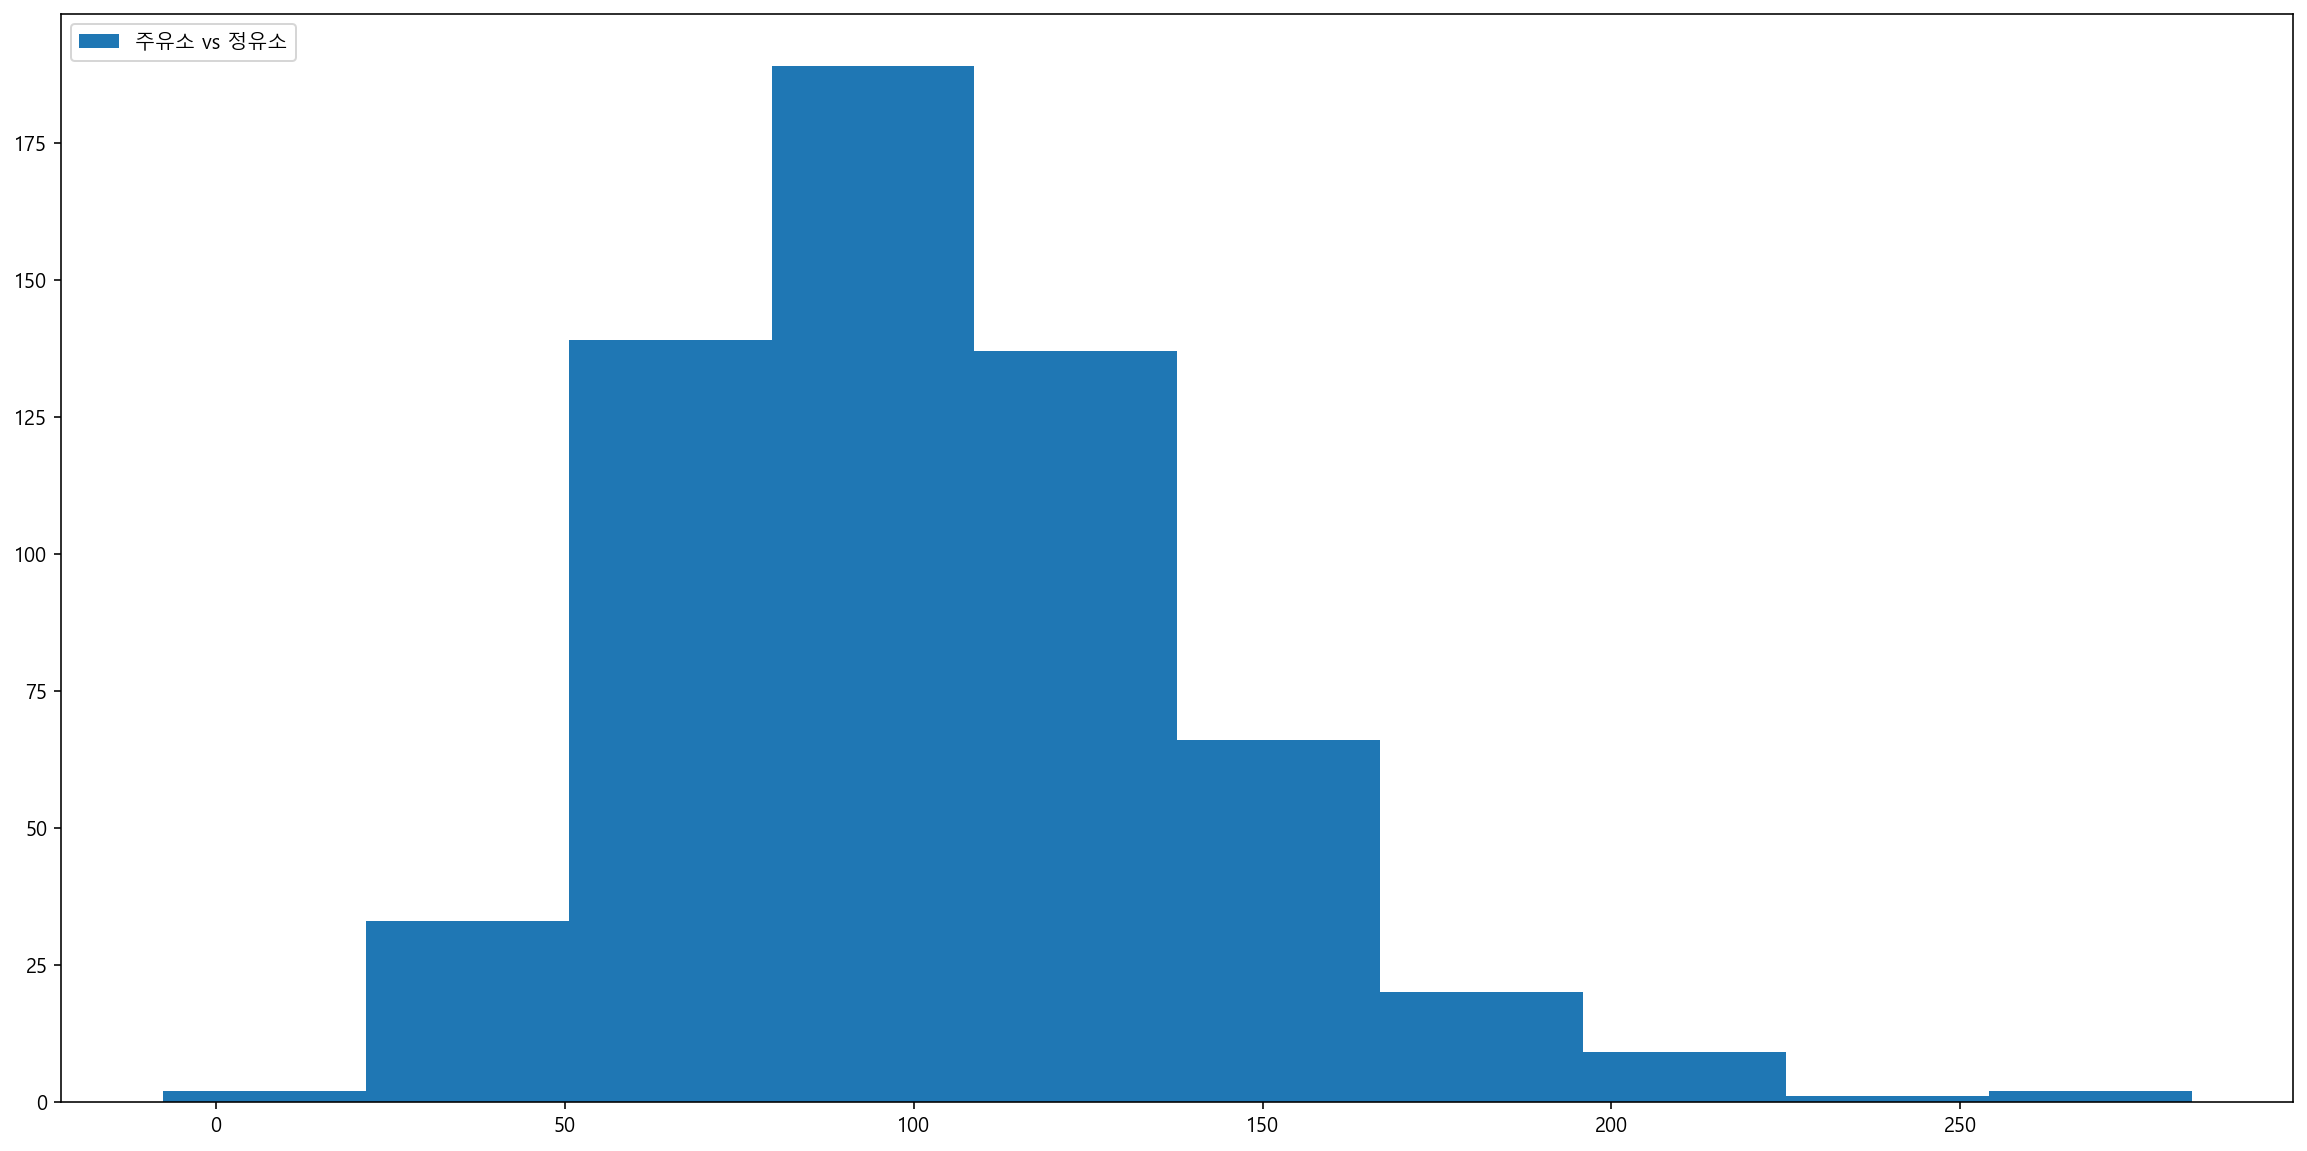

In [132]:
# 주유소와 정유소 가격차를 알아보기위한 희스토그램
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']

e= a-b

plt.hist(e,label='주유소 vs 정유소')
plt.legend(loc='upper left')

## 아리바 모델을 이용한 예측